In [1]:
import pandas as pd

df = pd.read_csv("/home/semipro321/OneDrive/School/McGill/Research Projects/Essay/essays_corrected_200.csv")  # Assume column 'text'
documents = df['corrected'].fillna('').tolist()


/home/semipro321/anaconda3/envs/py311/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Batches:   0%|          | 0/7 [00:00<?, ?it/s]

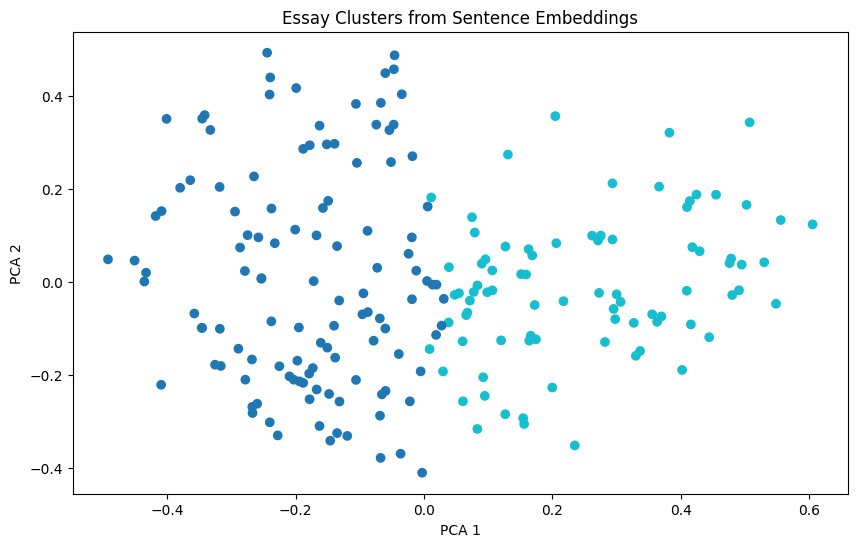

In [26]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained model (you can change this model to a more specific one if needed)
model = SentenceTransformer('all-MiniLM-L6-v2')  # small & fast, decent quality

embeddings = model.encode(documents, show_progress_bar=True)

from sklearn.metrics.pairwise import cosine_similarity

cos_sim_matrix = cosine_similarity(embeddings)

from sklearn.cluster import KMeans

k = 2  # Adjust as needed
km = KMeans(n_clusters=k, random_state=42)
labels = km.fit_predict(embeddings)

df['cluster'] = labels

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_reduced = PCA(n_components=2).fit_transform(embeddings)

plt.figure(figsize=(10, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=labels, cmap='tab10')
plt.title("Essay Clusters from Sentence Embeddings")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()


In [27]:
import numpy as np

i = 0  # index of target essay
similarities = cos_sim_matrix[i]
top_indices = np.argsort(similarities)[::-1][1:6]  # exclude self

print("Essay:", documents[i])
print("\nMost similar essays:")
for idx in top_indices:
    print(f"\n[Similarity: {similarities[idx]:.3f}]\n{documents[idx]}")


Essay: I live in a flat with my friend who is a teacher. I am a secretary I work in an office for a travel agent. We are both good friends and we cook our own meals and enjoy it alot. I go and visit my parents quite a lot, about three times a week I have to go quite a long way. I've got a dog which I take out every morning before breakfast because he is very lively. We live near the city centre so I can easily get to the shops and things. Sometimes at night my friend and I go out to the park (which is near our house) and we play tennis on the courts there. Every Saturday we mostly go to town and look round the shops at clothes and for groceries. My friend is an infant teacher and she enjoys her job very much, I also enjoy my job very much.

Most similar essays:

[Similarity: 0.709]
I have a job as an assistant in a shop. Five days a week I go there and enjoy it very much. It is a material shop. Things I like to do are reading, looking at clothes, walking and my job. I live in a flat ju

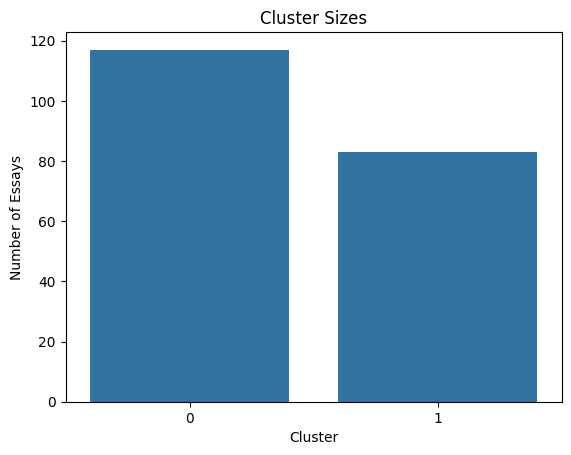

In [28]:
df['cluster'].value_counts().sort_index()
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='cluster', data=df)
plt.title("Cluster Sizes")
plt.xlabel("Cluster")
plt.ylabel("Number of Essays")
plt.show()


In [29]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

cluster_centroids = []

for cluster_id in sorted(df['cluster'].unique()):
    mask = df['cluster'] == cluster_id
    cluster_embeddings = embeddings[mask]
    centroid = cluster_embeddings.mean(axis=0)
    sims = cosine_similarity([centroid], cluster_embeddings)[0]
    idx_within_cluster = np.argmax(sims)
    global_idx = df[mask].index[idx_within_cluster]
    cluster_centroids.append(global_idx)

    print(f"\nCluster {cluster_id} centroid essay:\n", df.loc[global_idx, 'corrected'])



Cluster 0 centroid essay:
 One day I wrote a story about myself. I wrote this. I am twenty-five years old . I live in a sky-scraper . I have two children, a boy and a girl. Their names are [name] and [name]. I am a hairdresser. I like my job very much . I like back combing hair best of all it is sometimes boring because I don't know what to do when there is not a lot of people. We are always busy on a Saturday. My husband is a bus-driver. He has been with the corporation six pounds, one pound. I have a Wednesday off. We go visiting on a Wednesday afternoon . On a Wednesday morning we go shopping. I go down town to do my shopping. We stay in the twelfth floor there are eighteen floors in the sky-scraper. We always take the lift up but hardly ever take it down. [name] is one and a half years old and [name] is two and a half years old. [name] sometimes goes to Sunday school with the neighbours round about us. [name] and [name] go to a nursery every morning and afternoon while I work.

Cl

/home/semipro321/anaconda3/envs/py311/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


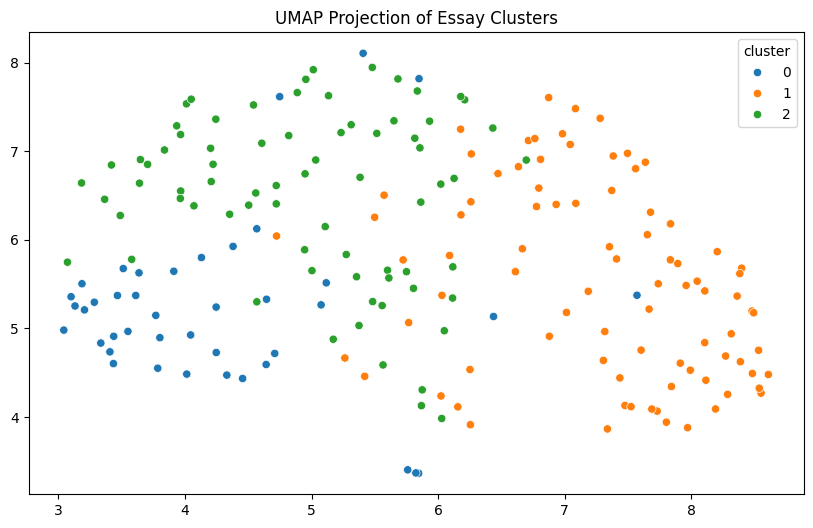

In [23]:

import umap.umap_ as umap


reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_embeddings = reducer.fit_transform(embeddings)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=umap_embeddings[:, 0], y=umap_embeddings[:, 1], hue=df['cluster'], palette='tab10')
plt.title("UMAP Projection of Essay Clusters")
plt.show()


In [19]:
within_similarities = []
between_similarities = []

for i in range(len(embeddings)):
    for j in range(i + 1, len(embeddings)):
        sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0][0]
        if df.loc[i, 'cluster'] == df.loc[j, 'cluster']:
            within_similarities.append(sim)
        else:
            between_similarities.append(sim)

print(f"Avg within-cluster similarity: {np.mean(within_similarities):.3f}")
print(f"Avg between-cluster similarity: {np.mean(between_similarities):.3f}")


Avg within-cluster similarity: 0.413
Avg between-cluster similarity: 0.296


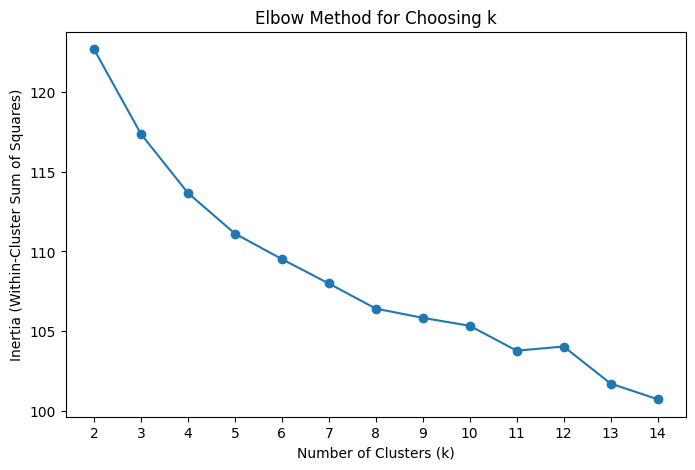

In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt

inertias = []
K_range = range(2, 15)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(embeddings)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Choosing k")
plt.xticks(K_range)
plt.show()


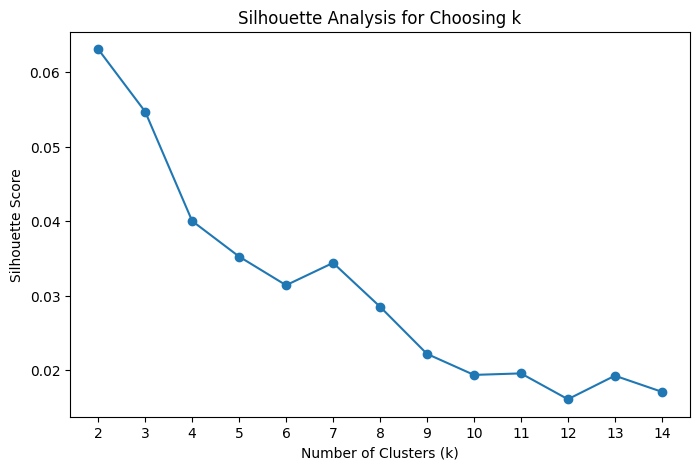

In [25]:
from sklearn.metrics import silhouette_score

sil_scores = []
K_range = range(2, 15)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    sil_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for Choosing k")
plt.xticks(K_range)
plt.show()
